#Installazione delle librerie

In [ ]:
!pip install librosa --upgrade #per analisi audio e musica
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

#Sezione Import

In [ ]:
import seaborn as sns
import pandas as pd
from datetime import datetime

# Drive e sistema
import os
import numpy as np
from google.colab import drive

# Audio processing
import librosa
import librosa.display
from IPython.display import Audio, display

# Visualizzazione
import matplotlib.pyplot as plt

# Machine learning e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

Importo il Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Progetto_Artificial_Intelligence/Dataset'

Mounted at /content/drive


#**Verifica delle classi e dei file audio**

##Controlliamo che le cartelle del dataset siano corrette (una per classe audio)

In [ ]:
CLASSES = sorted(os.listdir(DATA_DIR)) #Questa lista serve per associare ogni file a una classe numerica (etichetta da classificare)
print(f"Classi trovate: {CLASSES}")

Classi trovate: ['A', 'B', 'Barrel', 'C', 'D', 'E', 'F', 'Flage', 'G', 'PoffHon', 'Silence', 'Slap', 'Slide', 'n_metadata.csv']


#**Estrazione del Mel-Spectrogram**

##Convertiamo ogni file audio in una immagine tempo-frequenza (ideale per le CNN)

In [ ]:
def extract_mel_spectrogram(file_path, n_mels=128, max_len=128): # funzione che converte un file audio in spettrogramma Mel
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Riempi o ritaglia a lunghezza fissa (max_len)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

##**Costruzione del nuovo dataset**

##Trasformiamo tutti i file audio del dataset in immagini numeriche e raccogliamo le etichette.

In [ ]:
X = []
y = []

# Filtriamo CLASSES per includere solo directories
CLASSES = [label for label in CLASSES if os.path.isdir(os.path.join(DATA_DIR, label))]

for label in CLASSES:
    folder_path = os.path.join(DATA_DIR, label)
    for file in os.listdir(folder_path):
        if file.endswith('.wav') or file.endswith('.mp3'):
            file_path = os.path.join(folder_path, file)
            try:
                mel_spec = extract_mel_spectrogram(file_path)
                X.append(mel_spec)  # immagine del suono
                y.append(label)     # etichetta della cartella
            except Exception as e:
                print(f"Errore con il file {file_path}: {e}")

#**Preprocessing e codifica**

##Prepariamo i dati per il training

In [ ]:
X = np.array(X)[..., np.newaxis]  # trasformiamo X in un array NumPy
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # convertiamo y in numeri
y_categorical = to_categorical(y_encoded)   # rendiamo le etichette categoriche per l'output softmax della rete

print("Forma X:", X.shape)
print("Forma y:", y_categorical.shape)

Forma X: (234, 128, 128, 1)
Forma y: (234, 13)


#**Train/Test split**

##Dividiamo il dataset in un insieme per l’addestramento e uno per la valutazione

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

#**Definizione della rete neurale CNN**

##Definiamo il modello che impara a riconoscere i suoni

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,421 (28.20 MB)

 Trainable params: 7,393,421 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

#**Addestramento del modello**

##Facciamo apprendere al modello i pattern associati a ogni tipo di suono

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 789ms/step - accuracy: 0.0804 - loss: 204.8063 - val_accuracy: 0.1489 - val_loss: 41.3709
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 727ms/step - accuracy: 0.1697 - loss: 34.7772 - val_accuracy: 0.1915 - val_loss: 2.7001
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 992ms/step - accuracy: 0.3325 - loss: 2.5147 - val_accuracy: 0.5957 - val_loss: 1.3891
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step - accuracy: 0.6071 - loss: 1.3075 - val_accuracy: 0.8511 - val_loss: 0.5279
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - accuracy: 0.7400 - loss: 0.8532 - val_accuracy: 0.9362 - val_loss: 0.2959
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 911ms/step - accuracy: 0.8557 - loss: 0.4807 - val_accuracy: 0.9574 - val_loss: 0.1557
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 843ms/step - accuracy: 0.9543 - loss: 0.1577 - val_accuracy: 0.9787 - val_loss: 0.0688
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 897ms/step - accuracy: 0.9537 - loss: 0.1427 - val_accuracy: 0.9787 - val_l

#**Valutazione**

##Misuriamo le prestazioni su dati mai visti (test set)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0029
Accuracy sul test set: 1.00


#**Visualizzazione andamento**

##Aiuta a interpretare l’andamento dell’addestramento

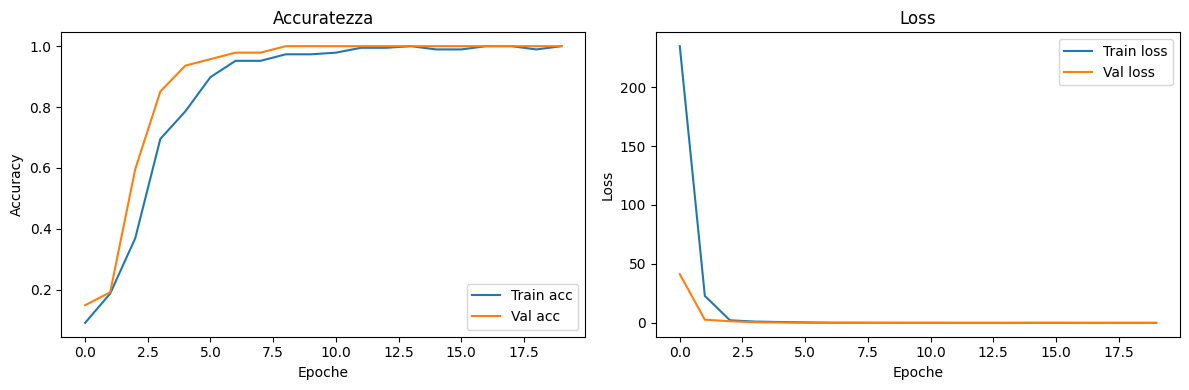

In [ ]:
plt.figure(figsize=(12, 4))

#con plt.plot(...) mostriamo accuracy e loss nel tempo

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

# Salvo la figura in Drive
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/acc_loss_plot1.png')
plt.show()

#**Salvataggio del modello addestrato**

##Serve per poter riutilizzare il modello senza riaddestrarlo ogni volta

In [ ]:
# Salviamo il modello in Drive
model.save('/content/drive/MyDrive/Progetto_Artificial_Intelligence/modello_chitarra.h5')

In [ ]:
# Per ricaricare il modello
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Progetto_Artificial_Intelligence/modello_chitarra.h5')

#**Visualizzazione di alcuni Mel-Spectrogram + etichette**

##Per capire visivamente cosa sta imparando la rete

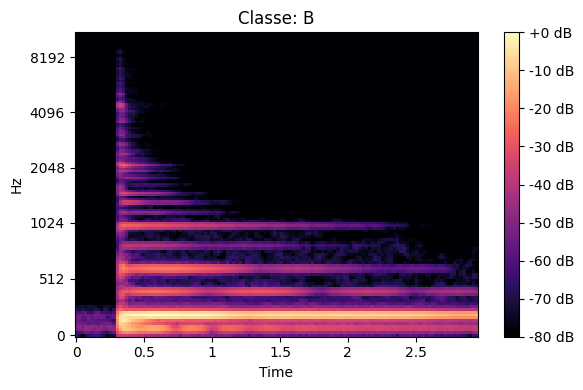

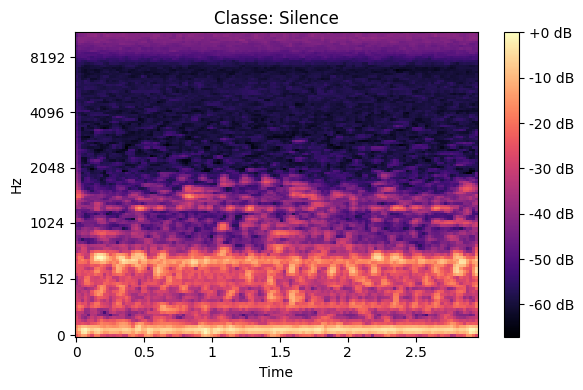

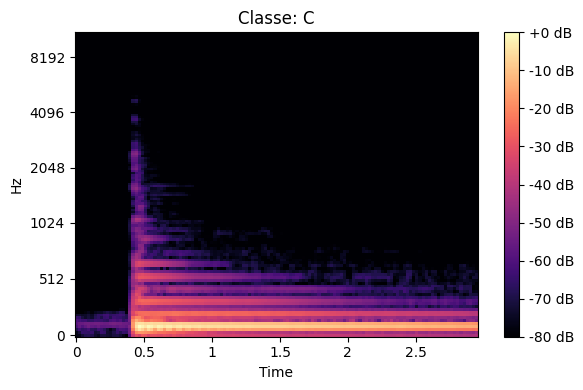

In [ ]:
# Visualizziamo 3 mel-spectrogram casuali
import random

indices = random.sample(range(len(X)), 3)
for i in indices:
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(X[i][:,:,0], sr=22050, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Classe: {label_encoder.inverse_transform([y_encoded[i]])[0]}")
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/mel_spectrogram.png')
    plt.show()

##**Confronto tra Mel-Spectrogram e MFCC**

##Serve per mostrare visivamente e tecnicamente la differenza tra due rappresentazioni audio

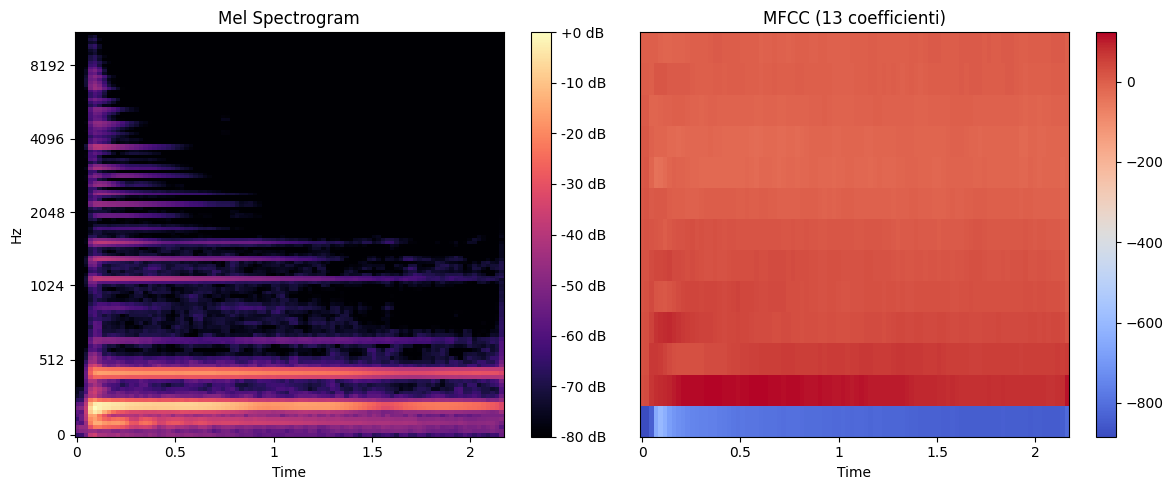

In [ ]:
file_path = os.path.join(DATA_DIR, CLASSES[0], os.listdir(os.path.join(DATA_DIR, CLASSES[0]))[0])
y, sr = librosa.load(file_path)

# Mel Spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

# MFCC
mfcc = librosa.feature.mfcc(S=mel_db, sr=sr, n_mfcc=13)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (13 coefficienti)')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/Mel-MFCC.png')
plt.show()

#**Confusion Matrix**

#Ha come scopo quello di visualizzare quali classi il modello confonde tra loro.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


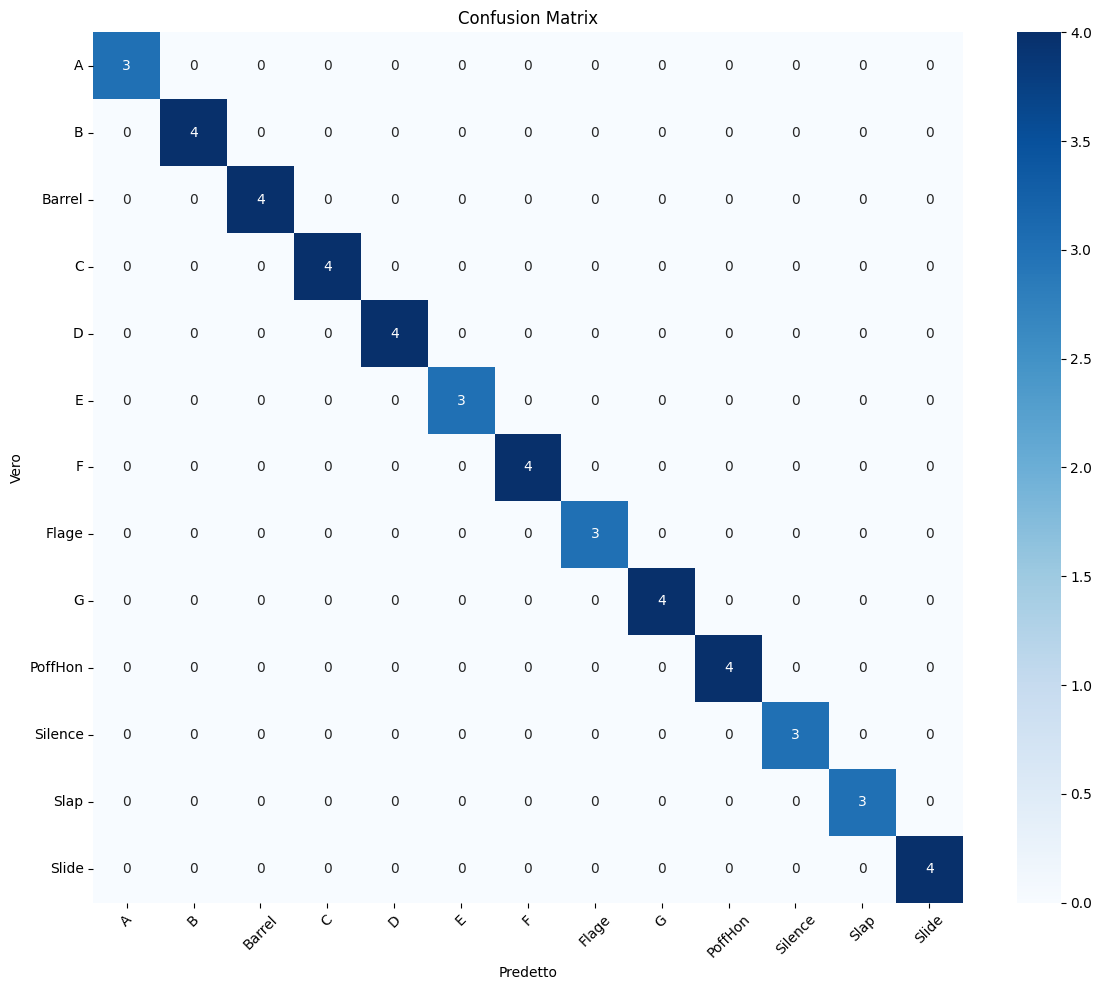

In [ ]:
# Otteniamo le predizioni del modello
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcolo e visualizzazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/confusion_matrix_plot1.png')
plt.show()

Per una versione normalizzata (percentuali invece di conteggi assoluti)

<Axes: >

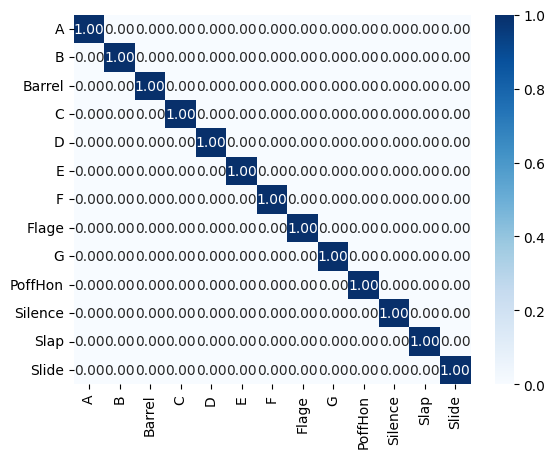

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

#**Transfer Learning**

##Utilizziamo modelli pre-addestrati su immagini (come VGG16) per analizzare spettrogrammi

In [ ]:
# Convertiamo gli spettrogrammi da 1 canale a 3 canali duplicando il contenuto
X_rgb = np.repeat(X, 3, axis=-1)  # da (n, 128, 128, 1) a (n, 128, 128, 3)

In [ ]:
# Alcuni import
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

Usiamo VGG16 senza l’ultima parte (classifier), e aggiungiamo i nostri layer di classificazione

In [ ]:
input_shape = (128, 128, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Congela tutti i layer della VGG16

# Costruiamo il modello sopra la VGG
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tl.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,029 (56.39 MB)

 Trainable params: 67,341 (263.05 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 richiede input normalizzati in un modo specifico (preprocess_input)

In [ ]:
X_rgb_preprocessed = preprocess_input(X_rgb)

Train/Test split e training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rgb_preprocessed, y_categorical, test_size=0.2, stratify=y_encoded)

history = model_tl.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.0339 - loss: 8.1094 - val_accuracy: 0.1277 - val_loss: 4.1539
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.1663 - loss: 4.4246 - val_accuracy: 0.2340 - val_loss: 2.2936
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.2781 - loss: 2.8951 - val_accuracy: 0.5106 - val_loss: 1.6674
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.4063 - loss: 2.2191 - val_accuracy: 0.6383 - val_loss: 1.3667
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.4870 - loss: 1.6556 - val_accuracy: 0.5957 - val_loss: 1.2093
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.5277 - loss: 1.4780 - val_accuracy: 0.5745 - val_loss: 1.1057
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.5245 - loss: 1.3410 - val_accuracy: 0.6809 - val_loss: 1.0372
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6157 - loss: 1.0894 - val_accuracy: 0.6809 - val_loss: 0.9971
Epoch 9/

Plot di Accuracy e Loss con salvataggio

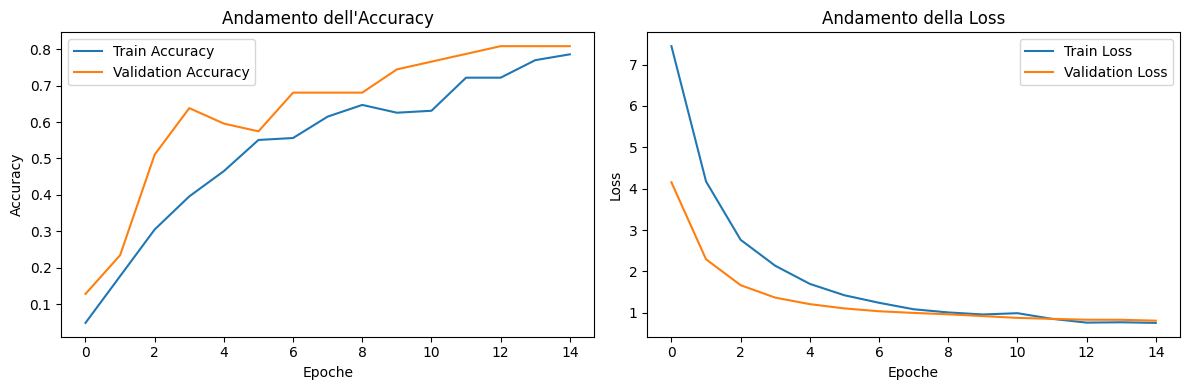

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento dell\'Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Andamento della Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

# Salvo la figura in Drive
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/acc_loss_plot2.png')

Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


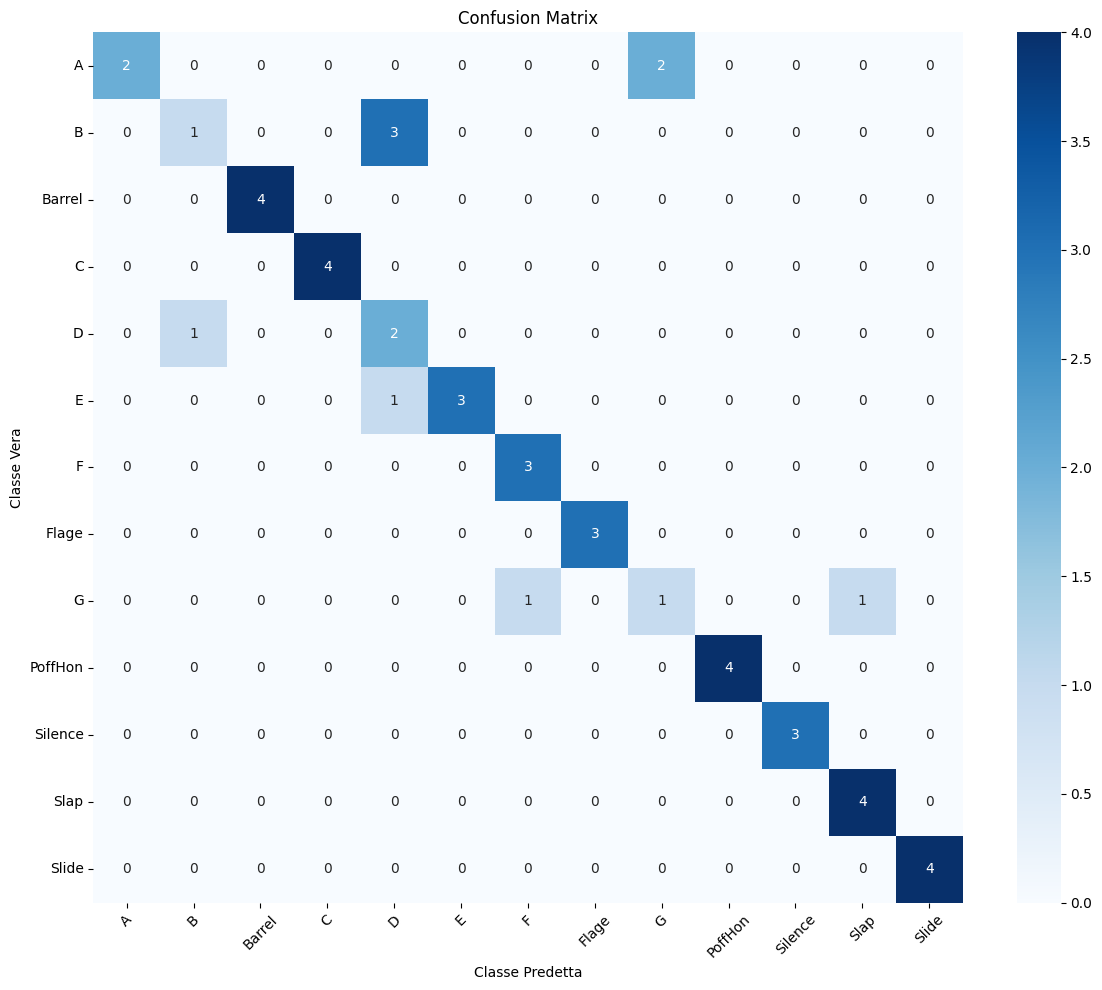

In [ ]:
# Predizioni sul test set
y_pred_probs = model_tl.predict(X_test)  # Usa model o model_tl
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Vera")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/confusion_matrix_plot2.png')
plt.show()

Variante: normalizzata (in percentuale)

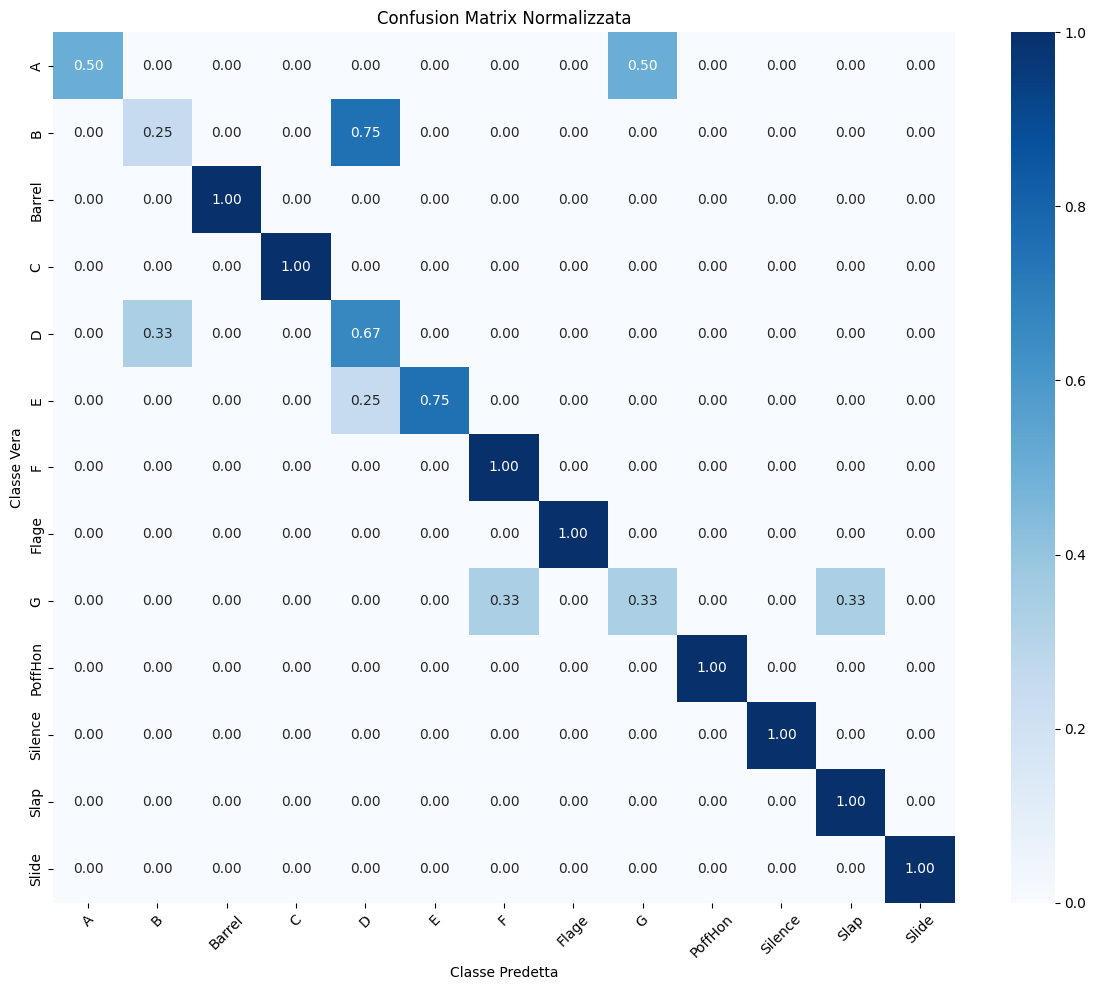

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Vera")
plt.title("Confusion Matrix Normalizzata")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#**Visualizzazione e ascolto dei dati**

##Serve a integrare nel notebook sia la visualizzazione dello spettrogramma sia l’ascolto del frammento audio corrispondente al mel-spectrogram generato

In [ ]:
#Funzione per mostrare spettrogramma + player audio
def show_and_play(file_path):
    # Carica segnale e rate
    y, sr = librosa.load(file_path, sr=None)

    # Mostra waveform
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/Waveform.png')
    plt.show()

    # Mostra mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-Spectrogram")
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/Mel_interattivo.png')
    plt.show()

    # Player audio interattivo
    display(Audio(data=y, rate=sr))

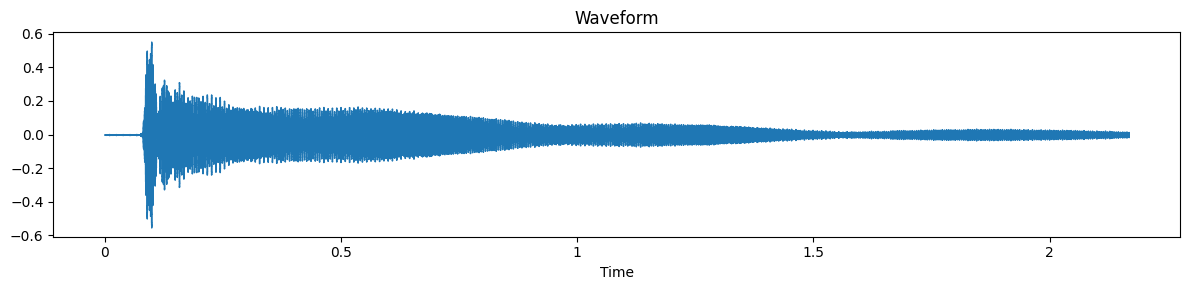

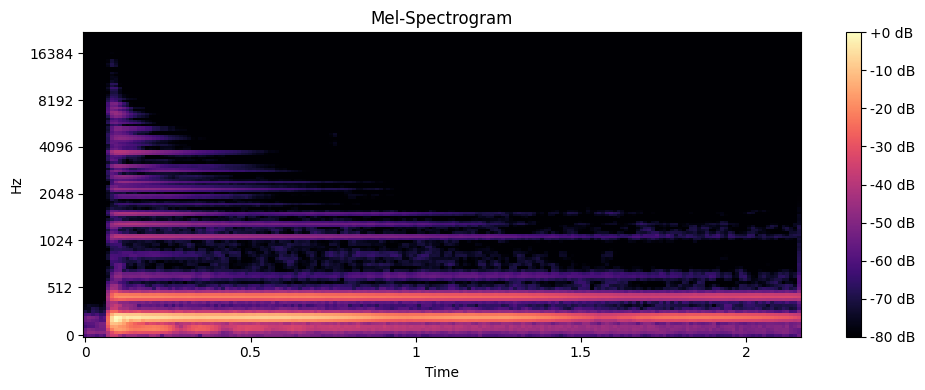

In [ ]:
file = os.path.join(DATA_DIR, CLASSES[0], os.listdir(os.path.join(DATA_DIR, CLASSES[0]))[0])
show_and_play(file)

##**Analisi degli errori**




##Serve per capire dove e perché il modello sbaglia, e per migliorarlo

In [ ]:
# Predizione
y_pred_probs = model_tl.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Visualizziamo ed esploriamo gli errori

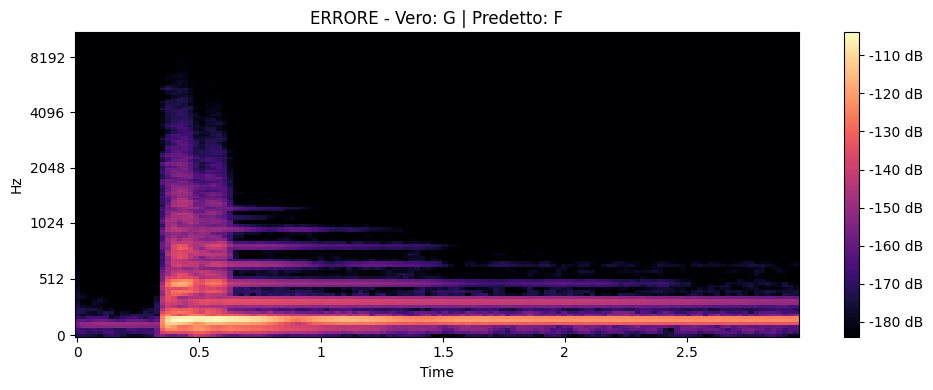

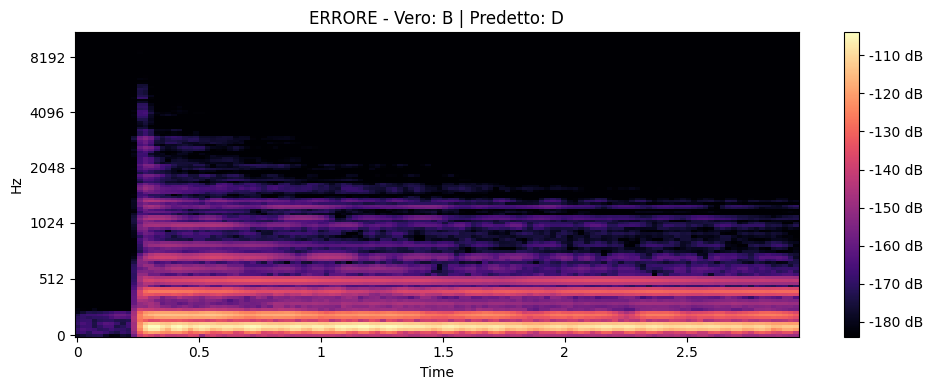

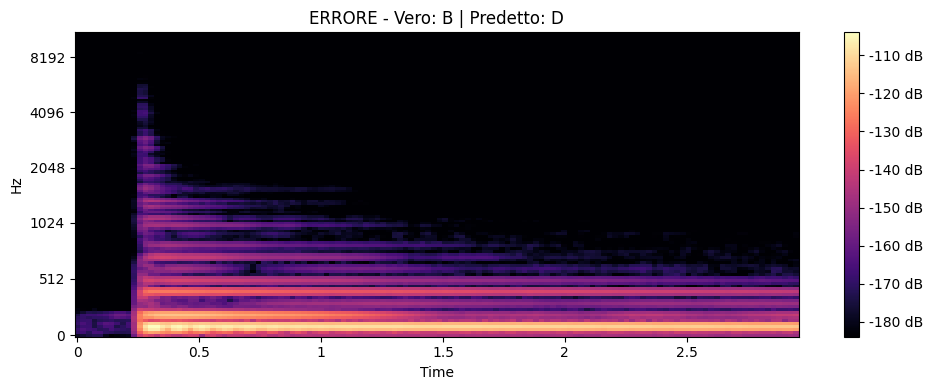

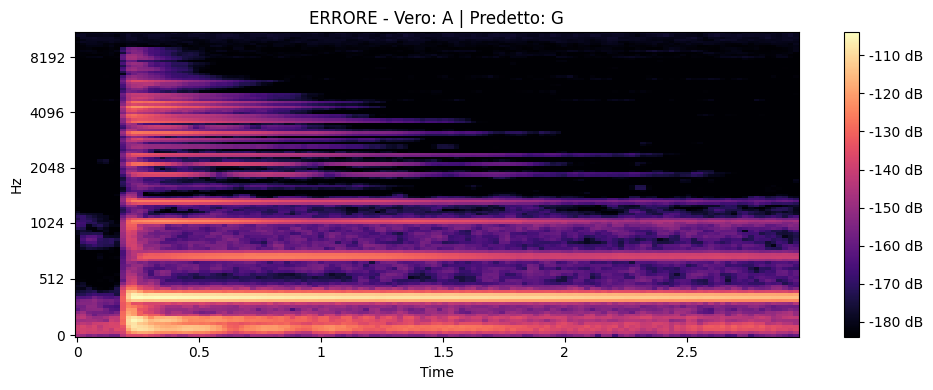

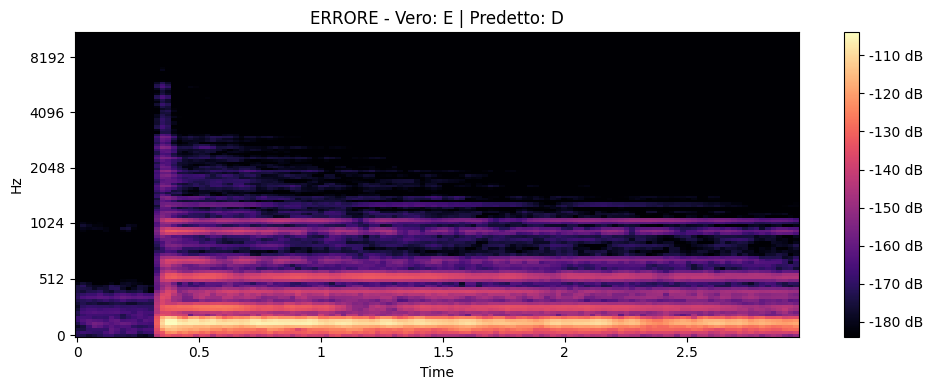

In [ ]:
# Troviamo gli indici degli esempi sbagliati
error_indices = np.where(y_true != y_pred)[0]

# Visualizziamo i primi 5 errori
for idx in error_indices[:5]:
    mel_spec = X_test[idx][:, :, 0]
    true_label = label_encoder.inverse_transform([y_true[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=22050)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"ERRORE - Vero: {true_label} | Predetto: {pred_label}")
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/Errore.png')
    plt.show() #Questo mostra l’immagine del mel-spectrogram associato all’errore e indica quali classi sono state confuse.

Per contare gli errori per classe

In [ ]:
confused = pd.DataFrame({'true': y_true, 'pred': y_pred})
confused['true_label'] = label_encoder.inverse_transform(confused['true'])
confused['pred_label'] = label_encoder.inverse_transform(confused['pred'])

print(confused[confused['true'] != confused['pred']].groupby(['true_label', 'pred_label']).size())

true_label  pred_label
A           G             2
B           D             3
D           B             1
E           D             1
G           F             1
            Slap          1
dtype: int64


#**Organizzazione e salvataggio dei risultati**

Salvataggio del modello

In [ ]:
model.save('/content/drive/MyDrive/Progetto_Artificial_Intelligence/modello_chitarra_finale.h5')

Aggiunta di varianti con timestamp per controllo delle versioni

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_name = f"model_{timestamp}.h5"
model.save(os.path.join('/content/drive/MyDrive/Progetto_Artificial_Intelligence/', model_name))

Salvataggio di accuracy e loss dopo l'addestramento

In [ ]:
history_dict = {
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'train_acc': history.history['accuracy'],
    'val_acc': history.history['val_accuracy']
}

df_hist = pd.DataFrame(history_dict)
df_hist.to_csv('/content/drive/MyDrive/Progetto_Artificial_Intelligence/history.csv', index=False)

Salvataggio della confusion matrix

In [ ]:
# Mi assicuro di usare il modello corretto (model_tl) e i dati preprocessati per VGG16 (X_rgb_preprocessed)
y_pred_probs = model_tl.predict(X_test) # Utilizza X_test che è stato splittato dopo la preprocessione per VGG16
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = label_encoder.classes_
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm.to_csv('/content/drive/MyDrive/Progetto_Artificial_Intelligence/confusion_matrix.csv')

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
